# Text Segmentation

### Assumptions
* The image has a dark background below the paper
* The writing is darker than the paper.
* The image is 1:1 aspect ratio

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(1000000)

### Read Image

In [2]:
img = cv2.resize(cv2.imread('hand.jpeg'), (600,600))

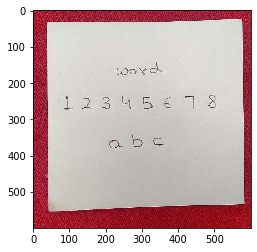

In [3]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Convert image to grayscale for processing 

In [4]:
img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

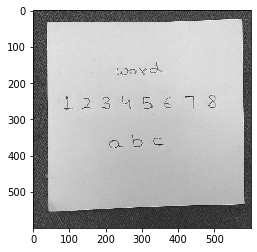

In [5]:
plt.imshow(cv2.cvtColor(img_g, cv2.COLOR_BGR2RGB))

## Paper Segmentation

In [6]:
hist = [0]*256
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        hist[img_g[i][j]]+=1
hist = np.array(hist)/sum(hist)

<BarContainer object of 256 artists>

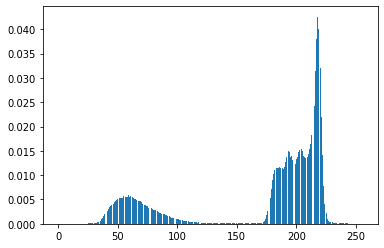

In [7]:
plt.bar(range(256), hist)

### Otsu's Thresholding for paper segmentation

In [8]:
thresh = 0
maxvar = 0
P1 = 0
P2 = 1
m1 = 0
m2 = sum([i*hist[i] for i in range(256)])
var = 0
for i in range(256):
    if(P1!=0 and P2!=0):
        var = P1*P2*((m1/P1-m2/P2)**2)
    P1 += hist[i]
    P2 -= hist[i]
    m1 += i*hist[i]
    m2 -= i*hist[i]
    if(var>maxvar):
        thresh = i
        maxvar = var

In [9]:
paper = (img_g>thresh)*1.0

### Clearing characters on the paper using closing followed by openning

In [10]:
paper = cv2.dilate(paper,np.ones((10,10)))
paper = cv2.erode(paper,np.ones((10,10)))
paper = cv2.erode(paper,np.ones((10,10)))
paper = cv2.dilate(paper,np.ones((10,10)))

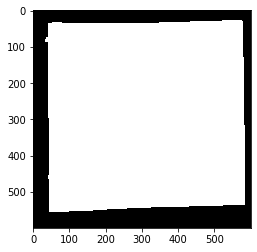

In [11]:
plt.imshow(paper, cmap = 'gray')

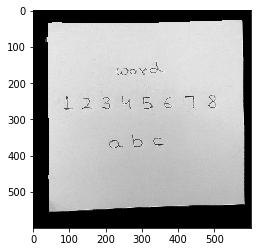

In [12]:
plt.imshow((paper*img_g).astype('uint8'), cmap = 'gray')

## Text Segmentation

### Considering only the paper pixels for Otsu's thresholding of the text

In [13]:
paper_hist = [0]*256
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(paper[i][j]>0.99):
            paper_hist[img_g[i][j]]+=1
paper_hist = np.array(paper_hist)/sum(paper_hist)

<BarContainer object of 256 artists>

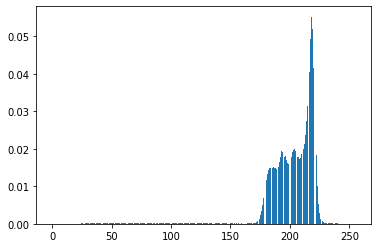

In [14]:
plt.bar([i for i in range(256)],paper_hist)

### Otsu's Thresholding to get Text Mask

In [15]:
thresh = 0
maxvar = 0
P1 = 0
P2 = 1
m1 = 0
m2 = sum([i*paper_hist[i] for i in range(256)])
var = 0
for i in range(256):
    if(P1*P2!=0):
        var = P1*P2*((m1/P1-m2/P2)**2)
    P1 += paper_hist[i]
    P2 -= paper_hist[i]
    m1 += i*paper_hist[i]
    m2 -= i*paper_hist[i]
    if(var>maxvar):
        thresh = i
        maxvar = var

In [16]:
text = paper*(((paper*img_g).astype('uint8') < thresh ) *1.0)

### Openning text with a (1,15) box kernel to join letters of a word 

In [17]:
textdash = cv2.dilate(text,np.ones((3,3)))
textdash = cv2.dilate(textdash,np.ones((1,15)))
textdash = cv2.erode(textdash,np.ones((1,15)))
text = ((text+textdash)>0.9)*1.0

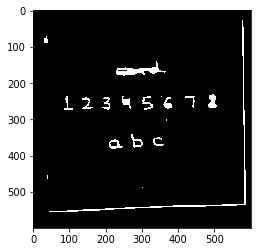

In [18]:
plt.imshow(text, cmap = 'gray')

## Bounding Box Prediction

### Using DFS to idetify connected components

In [19]:
def dfs(img, i, j, mx, Mx, my, My):
    mx = min(mx, i)
    Mx = max(Mx, i)
    my = min(my, j)
    My = max(My, j)
    img[i][j] = 0
    if(i+1<img.shape[0] and img[i+1][j]>0.5):
        m = dfs(img, i+1, j, mx, Mx, my, My)
        mx = min(mx, m[0])
        Mx = max(Mx, m[1])
        my = min(my, m[2])
        My = max(My, m[3])
    if(i>0 and img[i-1][j]>0.5):
        m = dfs(img, i-1, j, mx, Mx, my, My)
        mx = min(mx, m[0])
        Mx = max(Mx, m[1])
        my = min(my, m[2])
        My = max(My, m[3])
    if(j+1<img.shape[1] and img[i][j+1]>0.5):
        m = dfs(img, i, j+1, mx, Mx, my, My)
        mx = min(mx, m[0])
        Mx = max(Mx, m[1])
        my = min(my, m[2])
        My = max(My, m[3])
    if(j>0 and img[i][j-1]>0.5):
        m = dfs(img, i, j-1, mx, Mx, my, My)
        mx = min(mx, m[0])
        Mx = max(Mx, m[1])
        my = min(my, m[2])
        My = max(My, m[3])
    return [mx, Mx, my, My]

In [20]:
for i in range(text.shape[0]):
    for j in range(text.shape[1]):
        if(text[i][j]>0.5):
            m = dfs(text, i, j, float('inf'), -1, float('inf'), -1)
            if (m[1]-m[0])*(m[3]-m[2]) > 200 and (m[1]-m[0])*(m[3]-m[2]) < 600*150:
                img = cv2.rectangle(img, (m[2],m[0]), (m[3],m[1]), (0,0,255), 2)

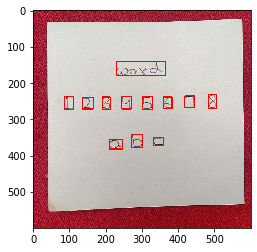

In [21]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [22]:
cv2.imshow('final', img)
cv2.waitKey(0)
cv2.destroyAllWindows()